In [1]:
__author__ = 'Marie Tagliavia <mtagliav@nd.edu>' # single string; emails in <>
__version__ = '20240522' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['NASA Exoplanet Archive']  # datasets used in this notebook
__keywords__ = ['exoplanets','stars','histogram','occurrence rates','Kepler'] # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/keywords.txt

# Exploring Trends in the Population of Giant Exoplanets

*Marie Tagliavia & the Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Loading in Data and a First Look](#load)
* [Comparing GEMS to other Giant Exoplanets](#allgems)
* [Debiasing Efforts](#debias)
* [GEMS and Giant Exoplanet Trends per Detection Method](#method)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals

The goal of this notebook is to uncover trends in the population of giant exoplanets $(radius > *R_\oplus, mass > 100 M_\oplus)$ with respect to the spectral type of their host stars. More specifically, this notebook seeks to explore whether the occurrence rate of giant planets around M-dwarf stars is in fact less than that around stars of hotter spectral types, as theorized in the notebook concept paper by Kanodia et al. 

# Summary

In their paper, Kanodia et al. set forth the inquiry "Do GEMS have a lower occurrence compared to similar giant planets in short orbital periods (the canonical hot Jupiters) around FGK stars?” They reason that M-dwarf stars likely form from less massive accretion disks, so their protoplanetary disks should also be smaller than those of more massive, hotter stars. This physical effect would lead to a lower occurrence rate of GEMS (Giant Exoplanets around M-dwarf Stars) than the occurrence rates of giant exoplanets around stars with hotter spectral types.

We begin this notebook by loading in a csv of the data from the NASA Exoplanet Archive using pandas capabilities and establishing the giant exoplanet population by filtering on physical bounds as well as excluding entries with NaNs. We then explore radius and mass trends of these giant exoplanets with respect to self-established basic spectral type classifications of their host stars, also calculating the occurrence rate of giant planets in planetary systems with respect to host star spectral type. After uncovering these trends for the entire giant exoplanet population currently known, we select only giant planets discovered through the Kepler mission and recalculate trends and occurrence rates. These recalculated trends and occurrence rates are roughly unbiased due to the nature in which Kepler took data. We finish by splitting the entire giant exoplanet population into detection method and recomputing trends and occurrence rates for the transit, radial velocity, and direct imaging methods.

For all three of these datasets, all robust measurements show that the occurrence rate of GEMS is lower than the occurrence rates of giant exoplanets around hotter, more massive stars with planetary systems, supporting Kanodia et al.'s prediction.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Notebook concept paper: Kanodia et al., "Searching for Giant Exoplanets around M-dwarf Stars (GEMS) I: Survey Motivation", The Astronomical Journal, 167(4), 161, 2024, doi: [10.3847/1538-3881/ad27cb](10.3847/1538-3881/ad27cb).
* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

This notebook was originally generated as part of the final project for ASTR 28500 "Science with Large Astronomical Surveys" at the University of Chicago.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
# Data Lab helpers as needed, e.g.: (uncomment as needed)
#from dl.helpers.utils import convert

<a class="anchor" id="load"></a>
# Loading in Data and a First Look

We first need to using `pandas` capabilities to load in the csv file containing our data and put its contents into a dataframe.

In [3]:
# read in csv file of NASA Exoplanet Archive data, print columns and shape
exo = pd.read_csv('exo_csv_final_upload.csv', delimiter=',')
print(exo.columns, exo.shape)

Index(['pl_name', 'hostname', 'default_flag', 'discoverymethod',
       'disc_facility', 'soltype', 'pl_controv_flag', 'pl_orbper',
       'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_masse', 'pl_massj', 'pl_msinie',
       'pl_msinij', 'pl_bmasse', 'pl_bmassj', 'st_refname', 'st_spectype',
       'st_teff', 'st_rad', 'st_mass', 'sy_refname', 'rastr', 'ra', 'decstr',
       'dec', 'sy_dist', 'sy_gaiamag'],
      dtype='object') (35964, 29)


Let's then take a first look at our data by graphing histograms of all planets based on mass and radius.

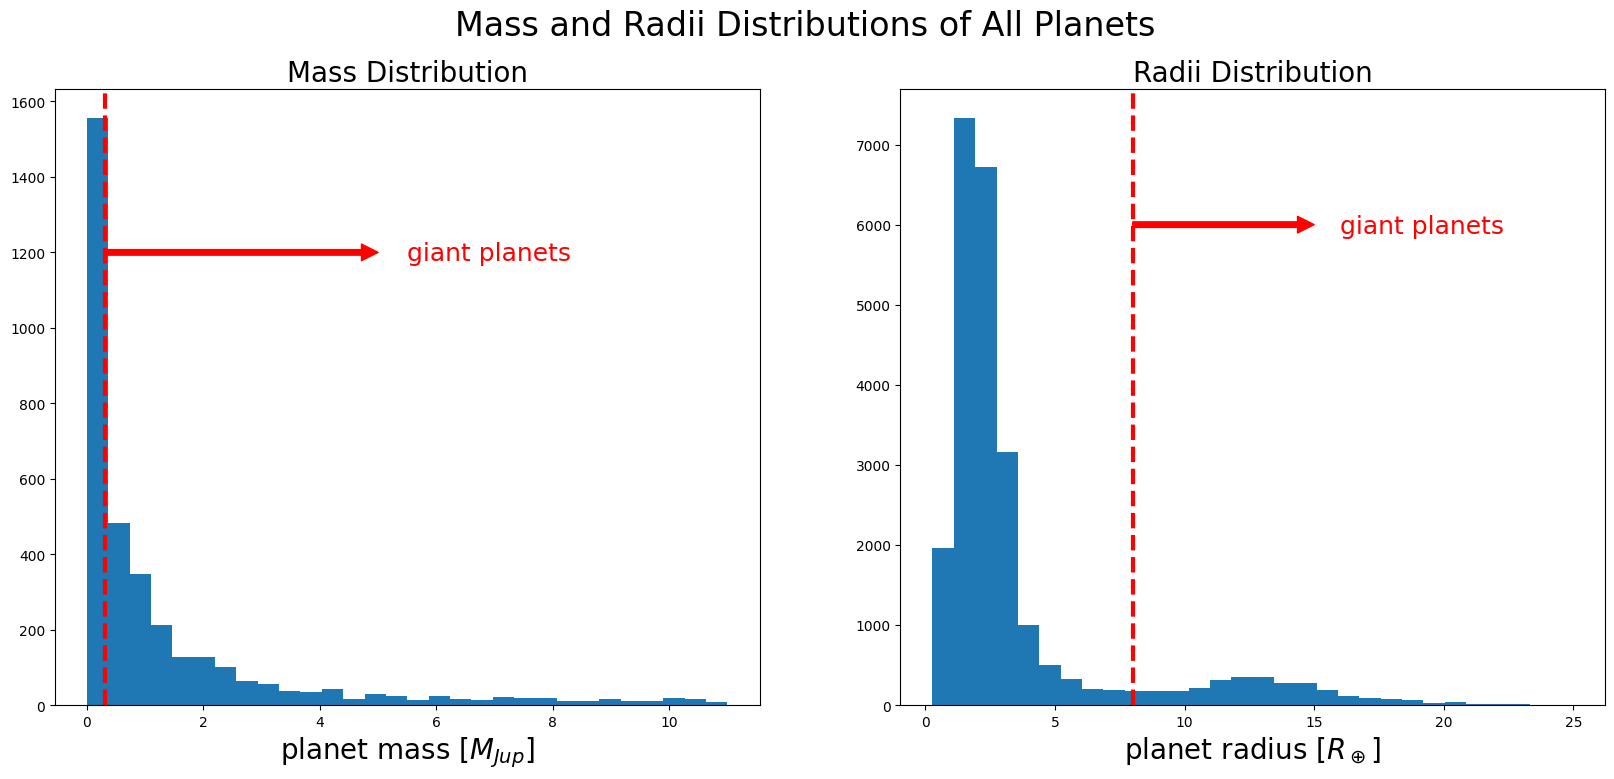

In [4]:
# graph 0: all planet masses, radii
plt.rcParams['figure.figsize'] = [20, 8]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle('Mass and Radii Distributions of All Planets', size=24)

axs[0].set_title('Mass Distribution', size=20)
axs[0].hist(exo.pl_massj[exo.pl_masse<11 * const.M_jup/const.M_earth], bins=30)
axs[0].set_xlabel(r'planet mass [$M_{Jup}$]', size=20)
axs[0].axvline(100*const.M_earth/const.M_jup, color='r', linestyle='dashed', lw=3)
axs[0].annotate('', (5,1200), xytext=(100*const.M_earth/const.M_jup,1200), arrowprops=dict(color='r'), color='r')
axs[0].annotate('giant planets', (5.5,1180), color='r', size=18)

axs[1].set_title('Radii Distribution', size=20)
axs[1].hist(exo.pl_rade[exo.pl_rade<25], bins=30)
axs[1].set_xlabel(r'planet radius [$R_\oplus$]', size=20)
axs[1].axvline(8, color='r', linestyle='dashed', lw=3)
axs[1].annotate('', (15,6000), xytext=(8,6000), arrowprops=dict(color='r'), color='r')
axs[1].annotate('giant planets', (16,5900), color='r', size=18)

plt.show()

The GEMS paper (Kanodia et al. 2024) informs us that giant exoplanets are defined as exoplanets that are greater than about 8 Earth radii and greater than about 100 Earth masses (but less than 13 Jupiter masses since these would be brown dwarfs [link](https://www.britannica.com/science/brown-dwarf)). These are truly giant planets; Neptune's radius is about $1.4 R_\oplus$ and Saturn's radius is about $9.13R_\oplus$.

In the graph above, we've included vertical lines to show where the realm of giant planets is (limiting our scope to planets with less than 11 Jupiter masses in an effort to filter out all brown dwarfs). We now apply these cuts along with NaNs cuts to the `exo` catalog and create `giant`:

In [5]:
# convert 13M_J to Earth masses
bd_M_lim = 11 * const.M_jup/const.M_earth  # brown dwarfs are 13 M_Jup or more (we apply restrictive bounds)
bd_R_lim = 25  # brown dwarfs are 0.7-1.4 R_jup, so this is mainly catching any nonphysicals values

giant_raw = exo[(exo.pl_rade>=8) & (exo.pl_rade<bd_R_lim) & ((exo.pl_masse>=100) | (exo.pl_msinie>=100)) 
                & ((exo.pl_masse<bd_M_lim) | (exo.pl_msinie<bd_M_lim))]  # with radius upper bound

# Keep an entry if there are no NaNs in st_teff, pl_rade, pl_orbsmax, and (pl_masse or pl_msinie)
temp_mask = ~np.isnan(giant_raw.st_teff)
rad_mask = ~np.isnan(giant_raw.pl_rade)
orb_mask = ~np.isnan(giant_raw.pl_orbsmax)
mass_mask = ~np.isnan(giant_raw.pl_masse) | ~np.isnan(giant_raw.pl_msinie)

tot_mask = temp_mask & rad_mask & orb_mask & mass_mask

# create giant catalog (giant) with this mask
giant = giant_raw[tot_mask]

Let's create the above histogram but only with giant exoplanets now:

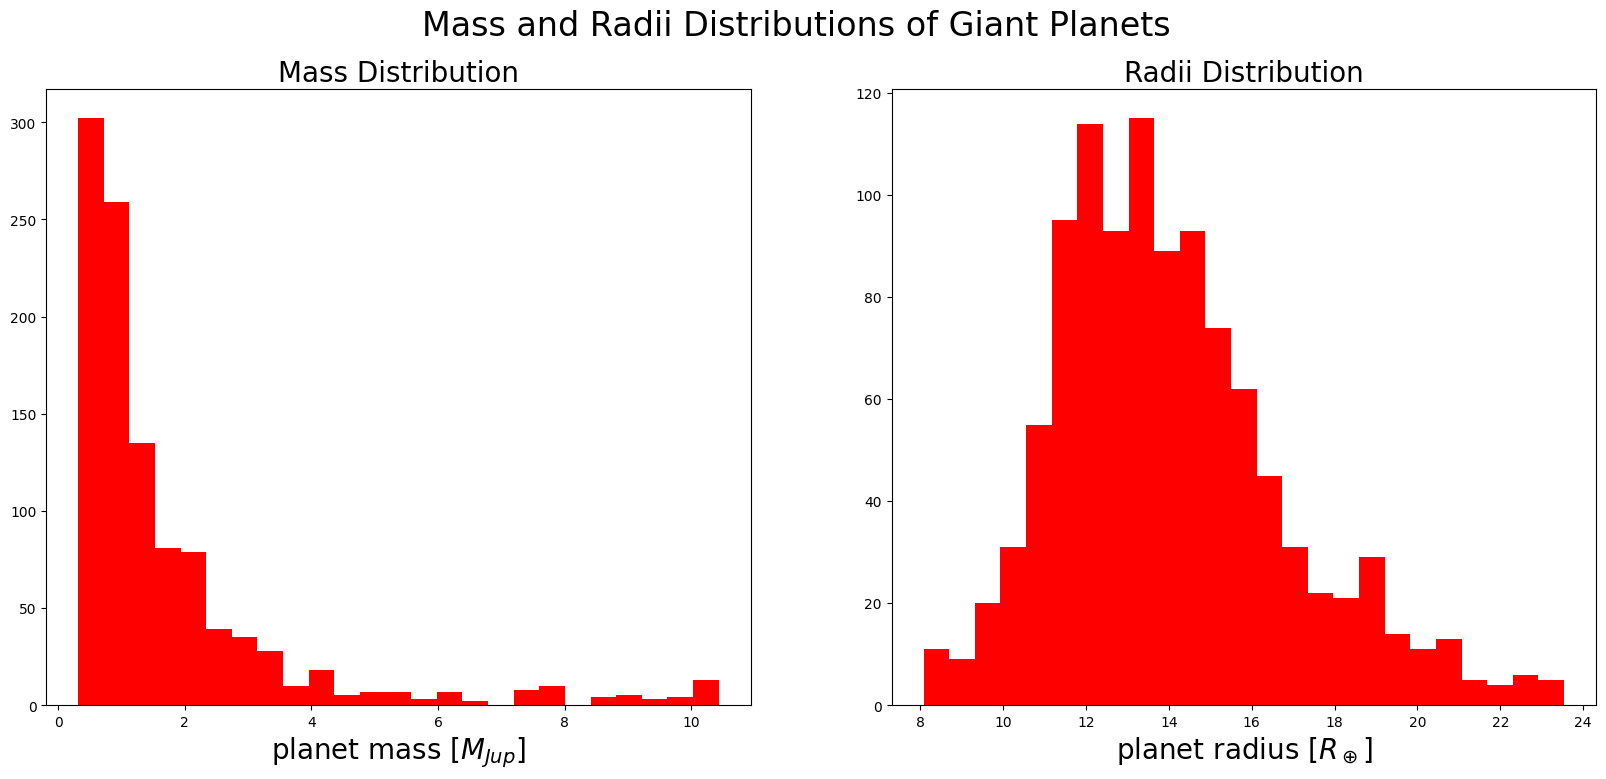

In [6]:
# graph 1: giant planet masses, radii
plt.rcParams['figure.figsize'] = [20, 8]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle('Mass and Radii Distributions of Giant Planets', size=24)

axs[0].set_title('Mass Distribution', size=20)
axs[0].hist(giant.pl_massj, bins=25, color='r')
axs[0].set_xlabel(r'planet mass [$M_{Jup}$]', size=20)

axs[1].set_title('Radii Distribution', size=20)
axs[1].hist(giant.pl_rade, bins=25, color='r')
axs[1].set_xlabel(r'planet radius [$R_\oplus$]', size=20)

plt.show()

As we expect, both of these graphs are skewed to higher values.

<a class="anchor" id="allgems"></a>
# Comparing GEMS to other giant exoplanets

GEMS are defined as "Giant Exoplanets orbiting M-dwarf Stars", where the paper defined M-dwarf stars as having an effective temperature of $T_{eff}\leq4000K$. However, the typical classification is $T_{eff}\leq3500K$. 

Upon further comparison of the NASA-assigned spectral type and effective temperature of the stars around 3500K and again around 4000K, it appears that the current approximate demarcation in the NASA Exoplanet Archive is 4000K. This is the value the GEMS paper uses and the value I will use as well. All other demarcations will remain the same as denoted below (see a table of the traditional demarcations [here](https://lco.global/spacebook/stars/types-stars/)).

Create a new column containing basic spectral type assignment based on effective temperature:

In [7]:
# assign spectral types to stars
# This paper classifies M-dwarfs as 4000K and below, but the general classification is 3500K and below
# Full table -- spectral type (my label): adjusted temperature range
# M (0): <4000K
# K (1): 4000K - 5000K
# G (2): 5000K - 6000K
# F (3): 6000K - 7500K
# A (4): 7500K - 10000K
# B (5): 10000K - 30000K
# O (6): >30000K

# spectral type range and init
sr = np.array([4000, 5000, 6000, 7500, 10000, 30000])
my_spec_type = np.zeros(giant.pl_masse.size, dtype='int')

# populate my_spec_type
for i in range(6):
    my_spec_type = np.where(giant.st_teff>=sr[i], i+1, my_spec_type)

giant['st_myspectype'] = my_spec_type
print(f'\nThere are {giant.pl_masse[(giant.st_myspectype==0)].size} GEMS in this catalog of {giant.pl_masse.size} giant planets.\n')


There are 28 GEMS in this catalog of 1067 giant planets.



/tmp/ipykernel_3302/3156826157.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giant['st_myspectype'] = my_spec_type


Let's look at a scatterplot of how giant exoplanets are distributed with respect to basic spectral type, with the color of each data point denoting the giant exoplanet's mass:

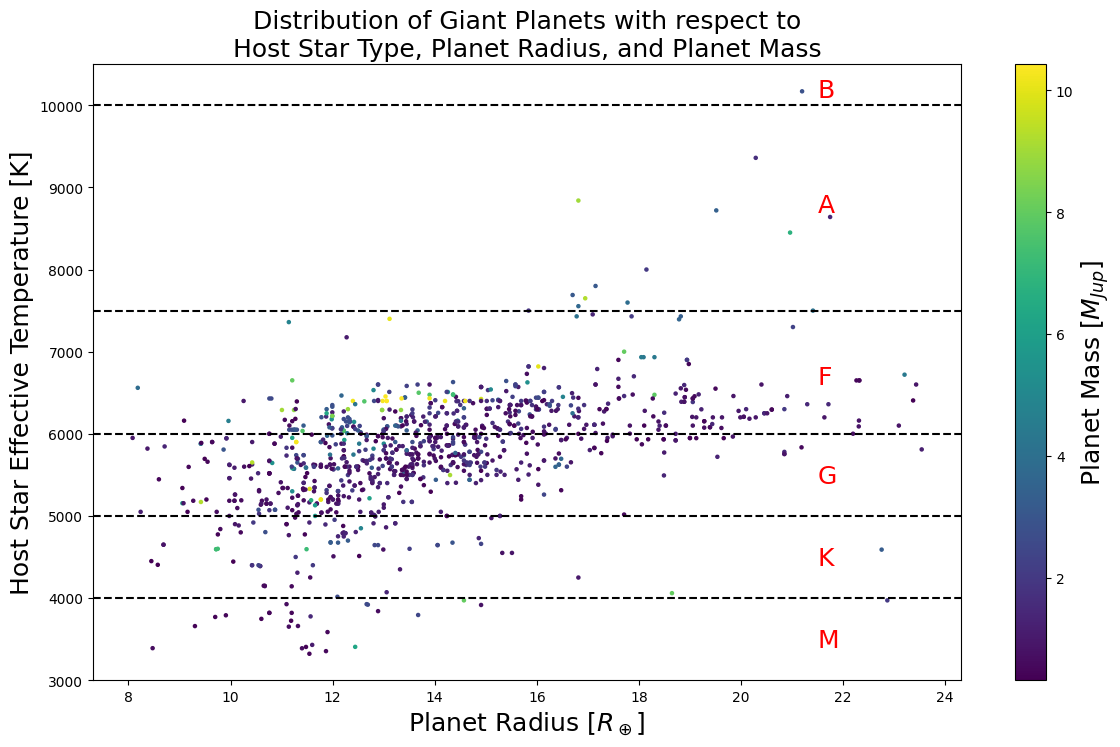

In [8]:
# graph 2: scatterplot
plt.figure(figsize=(14,8))
# plt.scatter(giant.pl_orbsmax, giant.st_teff, c=giant.pl_massj, s=5)  # pl_orbsmax
plt.scatter(giant.pl_rade, giant.st_teff, c=giant.pl_massj, s=5)  # pl_orbsmax
cbar = plt.colorbar()
cbar.set_label(r'Planet Mass [$M_{Jup}$]', rotation=90, size=18)
vst = np.array([3400, 4400, 5400, 6600, 8700, 10100])
st_label = ['M', 'K', 'G', 'F', 'A', 'B']
for i in range(5):
    plt.axhline(sr[i], linestyle='dashed', color='k')
    plt.annotate(st_label[i], (21.5,vst[i]), color='r', size=18)
plt.annotate(st_label[-1], (21.5,vst[-1]), color='r', size=18)
plt.title('Distribution of Giant Planets with respect to\nHost Star Type, Planet Radius, and Planet Mass', size=18)
plt.xlabel(r'Planet Radius [$R_\oplus$]', size=18)
plt.ylabel(r'Host Star Effective Temperature [K]', size=18)
# plt.xscale('log')
# plt.xlim((0.012,3))
plt.ylim((3000,10500))
plt.show()

Most giant exoplanets that have been discovered appear to be in orbit around stars with a basic spectral type of G or F. Note that very few GEMS have masses above 3 Jupiter masses, while these more massive giant exoplanets are more populous around stars of higher effective temperatures. This may be a physical effect of M-dwarf stars having smaller protoplanetary disks and thus less material to form planets from than more massive stars. 

We also note that while some giant planets orbiting hotter stars have very large radii for their masses (note especially trends for G- and F-type stars). These radii may be inflated due to the planets' proximity to their stars, making these potential hot Jupiters. However, GEMS tend to have smaller radii, which reflects the GEMS paper claim that even though GEMS may have short orbital periods, their lower effective temperature due to the lower output from their host star and other properties do not mark them specifically as hot Jupiters.

We may also be curious about the occurrence rate of GEMS compared to that of giant exoplanets around stars with higher effective temperatures:

Number of observed stars with planetary systems in each spectral type: [ 888  628 1881  760   22    9    3]
Number of giant planets orbiting stars of a certain spectral type: [ 28  77 536 412  13   1   0]


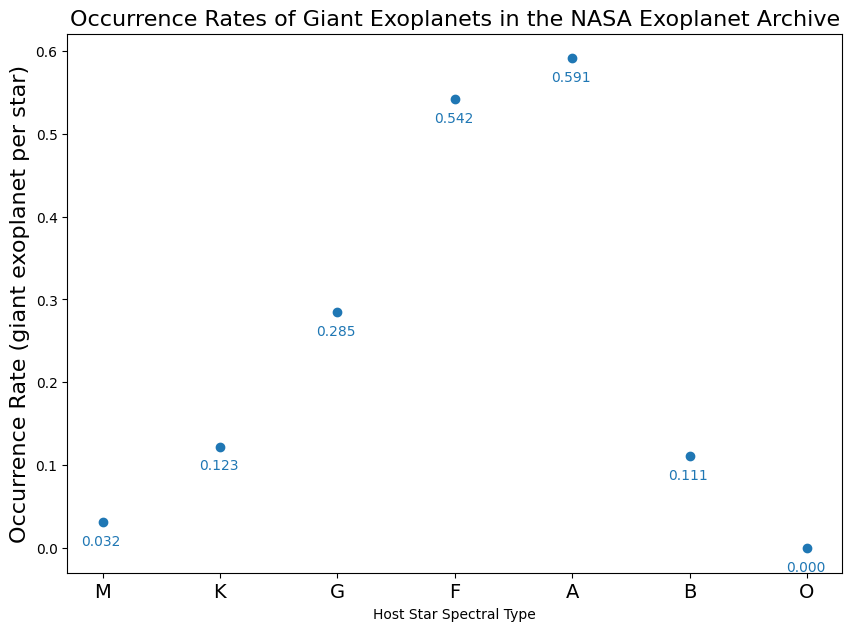

In [9]:
# graph 3: raw occurrence rate

# group exo catalog into my spectral types too
my_spec_type = np.zeros(exo.pl_masse.size, dtype='int')
# populate my_spec_type
for i in range(6):
    my_spec_type = np.where(exo.st_teff>=sr[i], i+1, my_spec_type)
exo['st_myspectype'] = my_spec_type

# now find the number of UNIQUE stars that are in each spectral class (spectype_counts)
star_names, star_ind = np.unique(exo.hostname, return_index=True)
unique_spectypes = exo.st_myspectype[star_ind]
_, spectype_counts = np.unique(unique_spectypes, return_counts=True)
print(f'Number of observed stars with planetary systems in each spectral type: {spectype_counts}')

# find number of giant planets for each type of star
_, giant_counts = np.unique(giant.st_myspectype, return_counts=True)
giant_counts = np.concatenate((giant_counts, np.array([0])))  # account for no giant planets around type O stars
print(f'Number of giant planets orbiting stars of a certain spectral type: {giant_counts}')

# graph
occ_bins = np.concatenate((np.array([2500]), sr, np.array([30100])))
occ_rates = giant_counts/spectype_counts

plt.figure(figsize=(10,7))
plt.scatter(np.array([1,2,3,4,5,6,7]), occ_rates)
my_xticks = ['M','K','G','F','A','B','O']
plt.xticks(np.array([1,2,3,4,5,6,7]), my_xticks, size=14)
plt.title('Occurrence Rates of Giant Exoplanets in the NASA Exoplanet Archive', size=16)
plt.xlabel('Host Star Spectral Type')
plt.ylabel('Occurrence Rate (giant exoplanet per star)', size=16)
for i in range(7):
    plt.annotate(f'{occ_rates[i]:.3f}', (i+0.82, occ_rates[i]-0.028), color='tab:blue')
plt.show()

We see that, for stars with an observed planetary system, the occurrence rate of giant exoplanets increases with stellar effective temperature up to type B and O stars. However since many exoplanet detection methods are less successful at detecting exoplanets around more massive stars, this decrease in occurrence rate at high stellar effective temperatures is likely at least partially due to this bias in detection methods.

<a class="anchor" id="debias"></a>
# Debiasing Efforts

As alluded to above, this dataset is not free of biases. One such bias is that for many detection methods, bigger planets with shorter periods orbiting smaller stars are the most easily detectable. (An exception to this is that direct imaging can more easily detect exoplanets at higher distances from their stars since the increased angular separation makes them easier to resolve from their star, but this will not affect us as much since planet semimajor axis is not a property we are specifically studying.) However, performing this debiasing in the context of the Occurrence Rates graph would serve only to intensify the trend of increasing rate of giant planet detection around hotter stars since we would predict to miss a higher proportion of planets around hotter stars and thus primarily occurrence rates for hotter spectral types would increase.

A bias that must be taken into account is the breadth of the individual surveys that contribute to the NASA Exoplanet Archive. Often, surveys have specific targets in mind and thus do not sample the stellar population equally. For example, MINERVA's goal of finding Earth-like exoplanets around Sun-like stars would boost the population of exoplanets around G-type stars without proportional boosts in the exoplanet populations for other spectral types. 

The Kepler mission, which observed the same section of sky for its entire duration, would be an example of an unbiased survey (with the fair assumption that spectral types are distributed randomly throughout the galaxy), and thus we proceed by reproducing the above scatterplots with only Kepler's exoplanet population.

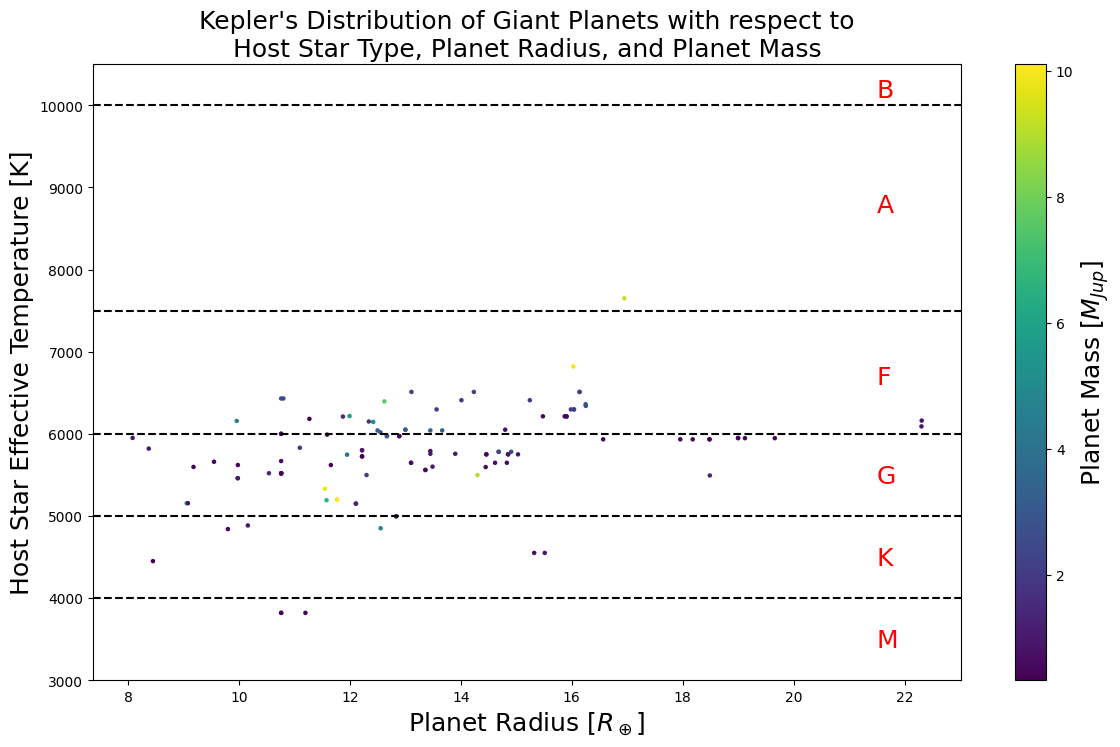

In [10]:
giant_kepler = giant[giant.disc_facility=='Kepler']
kepler = exo[exo.disc_facility=='Kepler']

# graph 2: scatterplot
plt.figure(figsize=(14,8))
# plt.scatter(giant.pl_orbsmax, giant.st_teff, c=giant.pl_massj, s=5)
plt.scatter(giant_kepler.pl_rade, giant_kepler.st_teff, c=giant_kepler.pl_massj, s=5)
cbar = plt.colorbar()
cbar.set_label(r'Planet Mass [$M_{Jup}$]', rotation=90, size=18)
vst = np.array([3400, 4400, 5400, 6600, 8700, 10100])
st_label = ['M', 'K', 'G', 'F', 'A', 'B']
for i in range(5):
    plt.axhline(sr[i], linestyle='dashed', color='k')
    plt.annotate(st_label[i], (21.5,vst[i]), color='r', size=18)
plt.annotate(st_label[-1], (21.5,vst[-1]), color='r', size=18)
plt.title("Kepler's Distribution of Giant Planets with respect to\nHost Star Type, Planet Radius, and Planet Mass", size=18)
plt.xlabel(r'Planet Radius [$R_\oplus$]', size=18)
plt.ylabel(r'Host Star Effective Temperature [K]', size=18)
# plt.xscale('log')
# plt.xlim((0.012,3))
plt.ylim((3000,10500))
plt.show()

Number of Kepler-observed stars with planetary systems in each spectral type (excluding type O): [ 105  266 1139  466    3    3]
Number of Kepler-observed giant planets orbiting stars of a certain spectral type (excluding type O): [ 3  8 64 37  1  0]


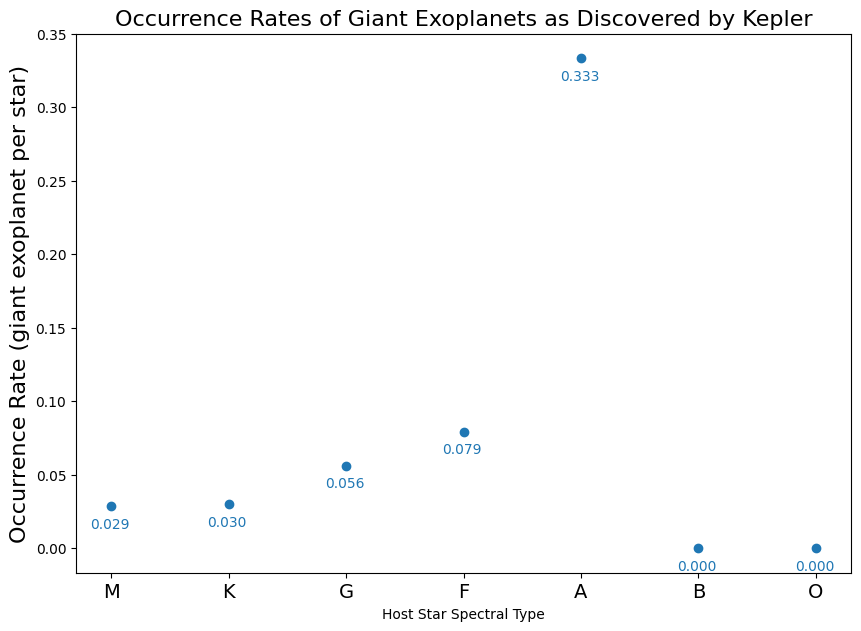

In [11]:
# now find the number of UNIQUE Kepler stars that are in each spectral class (spectype_counts)
star_names, star_ind = np.unique(kepler.hostname, return_index=True)
unique_spectypes = kepler['st_myspectype'].iloc[star_ind]
_, spectype_counts = np.unique(unique_spectypes, return_counts=True)
print(f'Number of Kepler-observed stars with planetary systems in each spectral type (excluding type O): {spectype_counts}')

# find number of giant planets for each type of star
_, giant_counts = np.unique(giant_kepler.st_myspectype, return_counts=True)
giant_counts = np.concatenate((giant_counts, np.array([0])))  # account for no giant planets around type B stars
print(f'Number of Kepler-observed giant planets orbiting stars of a certain spectral type (excluding type O): {giant_counts}')

# graph
occ_bins = np.concatenate((np.array([2500]), sr, np.array([30100])))
occ_rates = np.concatenate((giant_counts/spectype_counts, np.array([0])))  # account for no giant planets around type O stars

plt.figure(figsize=(10,7))
plt.scatter(np.array([1,2,3,4,5,6,7]), occ_rates)
my_xticks = ['M','K','G','F','A','B','O']
plt.xticks(np.array([1,2,3,4,5,6,7]), my_xticks, size=14)
plt.title('Occurrence Rates of Giant Exoplanets as Discovered by Kepler', size=16)
plt.xlabel('Host Star Spectral Type')
plt.ylabel('Occurrence Rate (giant exoplanet per star)', size=16)
for i in range(7):
    plt.annotate(f'{occ_rates[i]:.3f}', (i+0.82, occ_rates[i]-0.015), color='tab:blue')
plt.show()

From these two graphs, we continue to observe the trend of GEMS being less common around their M-dwarf stars with planetary systems than other giant planets around their stars of hotter spectral types with planetary systems. While the trend is less extreme when considering the occurrence rate difference between M- and K-dwarf stars, there is still a significant difference between M-dwarf and G-, F-, and A-dwarf giant planet occurrence rates. This roughly-debiased finding supports the GEMS paper theory that GEMS should have a lower occurrence rate than giant planets around hotter stars.

<a class="anchor" id="method"></a>
# GEMS and Giant Exoplanet Trends per Detection Method

Along with our roughly-debiased method of computing general giant planet occurrence rates using the Kepler planets, we can also analyze giant planet occurrence rates with respect to different exoplanet detection methods, each of which comes along with its own biases.

Of the detection methods, the transit method has discovered the most exoplanets. Transit surveys are biased in two main ways: squared ratio of planet radius to host star radius, and period of the planet. Since the transit method discovers a planet via the proportion of host star light it obscures, aforementioned ratios that are larger have a higher probability of being detected, with the effect of larger exoplanets being easier to detect for a given host star spectral type. Transit surveys are also limited by needing three transits in order to confirm the existence of an exoplanet, so only planets with a short-enough period can be detected. The radial velocity method is also a common method for exoplanet detection. Similar to the transit method, it is biased toward the detection of massive planets (in proportion to their star) with short periods. The direct imaging method is less common, but as previously mentioned is biased toward detecting exoplanets at higher distances from their stars since the increased angular separation makes them easier to resolve.

For all three techniques, larger planets around cooler stars are easier to detect, so debiasing the following data would serve only to intensify the trend of smaller giant planet occurrence rates for stars with cooler spectral types.

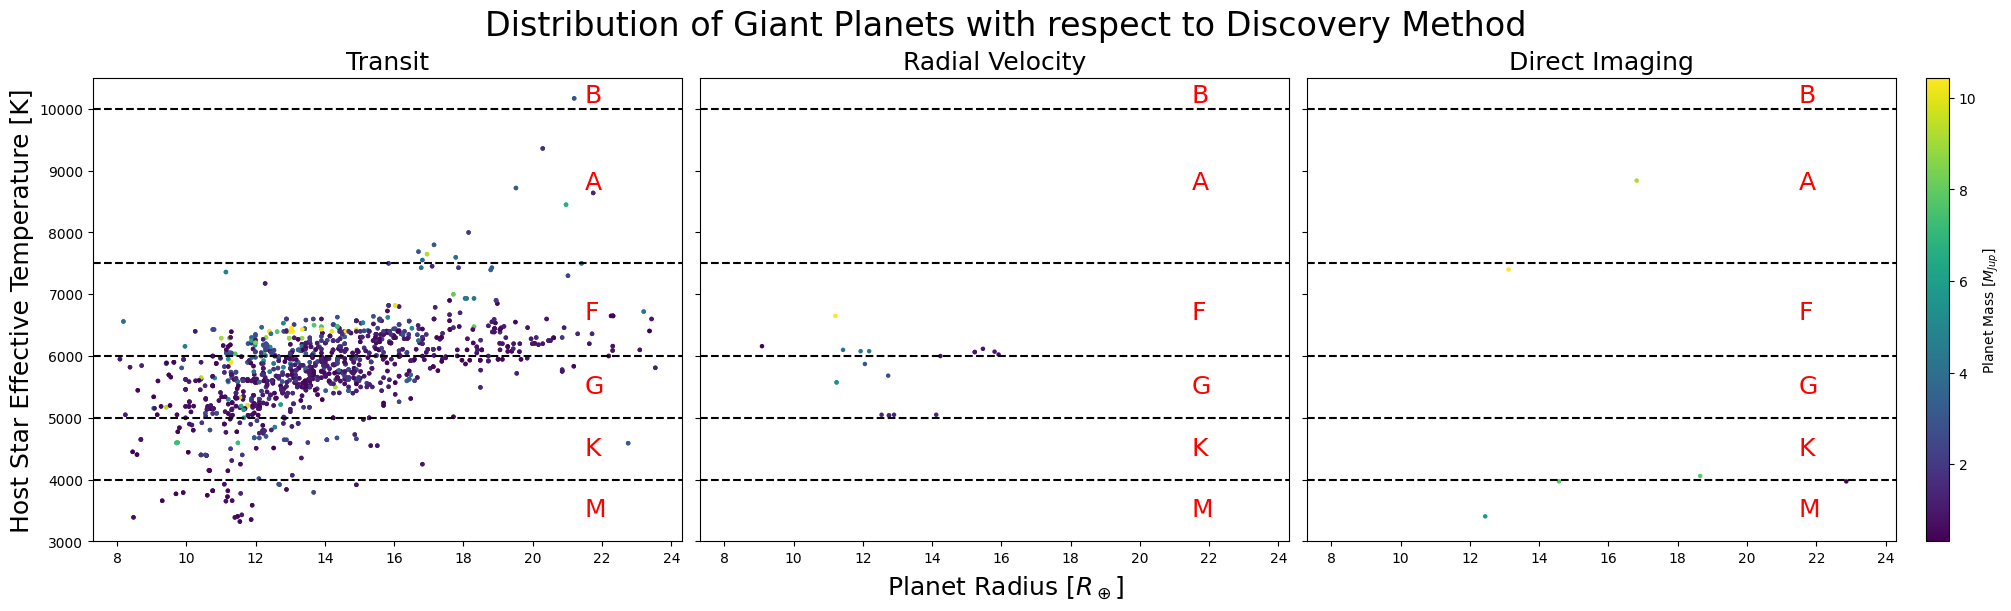

In [12]:
# create dataframes with only transit-discovered, radial-velocity-discovered, 
#  and direct-imaging-discovered giant planets
giant_transit = giant[giant.discoverymethod=='Transit']
giant_radial = giant[giant.discoverymethod=='Radial Velocity']
giant_image = giant[giant.discoverymethod=='Imaging']
# and for all planets too
exo_transit = exo[exo.discoverymethod=='Transit']
exo_radial = exo[exo.discoverymethod=='Radial Velocity']
exo_image = exo[exo.discoverymethod=='Imaging']

# graph
plt.rcParams['figure.figsize'] = [20, 6]
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, layout='constrained')
fig.suptitle('Distribution of Giant Planets with respect to Discovery Method', size=24)

axs[0].scatter(giant_transit.pl_rade, giant_transit.st_teff, c=giant_transit.pl_massj, s=5)
axs[1].scatter(giant_radial.pl_rade, giant_radial.st_teff, c=giant_radial.pl_massj, s=5)
axs[2].scatter(giant_image.pl_rade, giant_image.st_teff, c=giant_image.pl_massj, s=5)
cbar0 = axs[0].scatter(giant_transit.pl_rade, giant_transit.st_teff, c=giant_transit.pl_massj, s=5)
fig.colorbar(cbar0, ax=axs[2], location='right', label=r'Planet Mass [$M_{Jup}$]')
vst = np.array([3400, 4400, 5400, 6600, 8700, 10100])
st_label = ['M', 'K', 'G', 'F', 'A', 'B']
for j in range(3):
    for i in range(5):
        axs[j].axhline(sr[i], linestyle='dashed', color='k')
        axs[j].annotate(st_label[i], (21.5,vst[i]), color='r', size=18)
    axs[j].annotate(st_label[-1], (21.5,vst[-1]), color='r', size=18)
fig.supxlabel(r'Planet Radius [$R_\oplus$]', size=18)
axs[0].set_ylabel(r'Host Star Effective Temperature [K]', size=18)
axs[0].set_title(r'Transit', size=18)
axs[1].set_title(r'Radial Velocity', size=18)
axs[2].set_title(r'Direct Imaging', size=18)
# plt.xscale('log')
# plt.xlim((0.012,3))
plt.ylim((3000,10500))
plt.show()

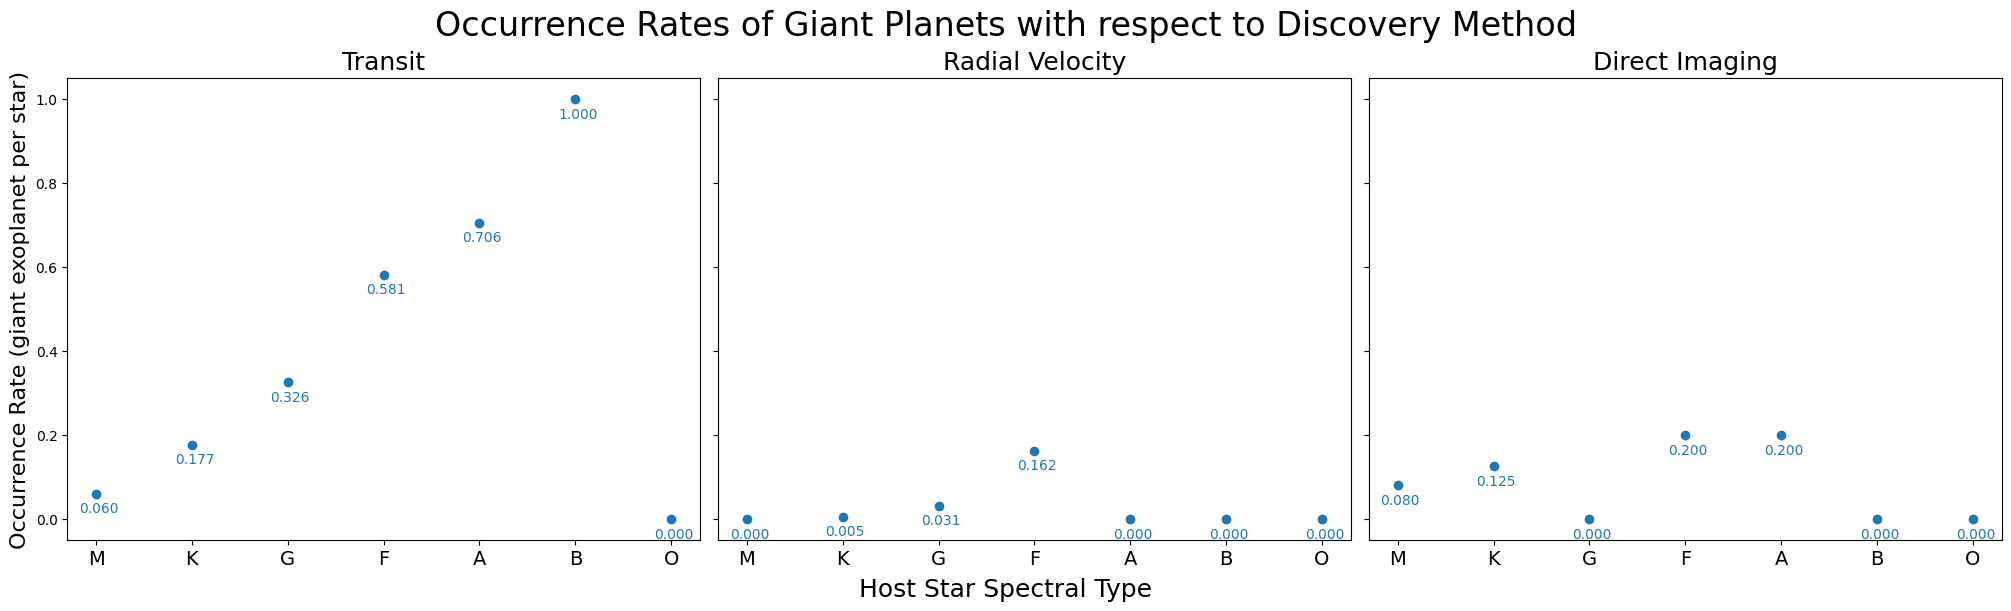

In [13]:
# now find the number of UNIQUE Kepler stars that are in each spectral class (spectype_counts)

plt.rcParams['figure.figsize'] = [20, 6]
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, layout='constrained')
fig.suptitle('Occurrence Rates of Giant Planets with respect to Discovery Method', size=24)
fig.supxlabel(r'Host Star Spectral Type', size=18)

# Transit
star_names, star_ind = np.unique(exo_transit.hostname, return_index=True)
unique_spectypes = exo_transit['st_myspectype'].iloc[star_ind]
_, spectype_counts = np.unique(unique_spectypes, return_counts=True)
# print(f'Number of transit-observed stars with planetary systems in each spectral type (excluding type O): {spectype_counts}')
# find number of giant planets for each type of star
_, giant_counts = np.unique(giant_transit.st_myspectype, return_counts=True)
# print(f'Number of transit-observed giant planets orbiting stars of a certain spectral type (excluding type O): {giant_counts}')
# graph
occ_bins = np.concatenate((np.array([2500]), sr, np.array([30100])))
occ_rates = np.concatenate((giant_counts/spectype_counts, np.array([0])))  # account for no giant planets around type O stars
axs[0].scatter(np.array([1,2,3,4,5,6,7]), occ_rates)
my_xticks = ['M','K','G','F','A','B','O']
axs[0].set_xticks(np.array([1,2,3,4,5,6,7]), my_xticks, size=14)
axs[0].set_ylabel('Occurrence Rate (giant exoplanet per star)', size=16)
axs[0].set_title('Transit', size=18)
for i in range(7):
    axs[0].annotate(f'{occ_rates[i]:.3f}', (i+0.82, occ_rates[i]-0.045), color='tab:blue')

# Radial Velocity
star_names, star_ind = np.unique(exo_radial.hostname, return_index=True)
unique_spectypes = exo_radial['st_myspectype'].iloc[star_ind]
_, spectype_counts = np.unique(unique_spectypes, return_counts=True)
# print(f'Number of radial-velocity-observed stars with planetary systems in each spectral type (excluding type O): {spectype_counts}')
# find number of giant planets for each type of star
_, giant_counts = np.unique(giant_radial.st_myspectype, return_counts=True)
giant_counts = np.concatenate((np.array([0]), giant_counts))
# print(f'Number of radial-velocity-observed giant planets orbiting stars of a certain spectral type (excluding type O): {giant_counts}')
# graph
occ_bins = np.concatenate((np.array([2500]), sr, np.array([30100])))
occ_rates = np.concatenate((giant_counts/spectype_counts, np.array([0,0,0])))  # account for no giant planets around type O stars
axs[1].scatter(np.array([1,2,3,4,5,6,7]), occ_rates)
my_xticks = ['M','K','G','F','A','B','O']
axs[1].set_xticks(np.array([1,2,3,4,5,6,7]), my_xticks, size=14)
axs[1].set_title('Radial Velocity', size=18)
for i in range(7):
    axs[1].annotate(f'{occ_rates[i]:.3f}', (i+0.82, occ_rates[i]-0.045), color='tab:blue')

# Direct Imaging
star_names, star_ind = np.unique(exo_image.hostname, return_index=True)
unique_spectypes = exo_image['st_myspectype'].iloc[star_ind]
_, spectype_counts = np.unique(unique_spectypes, return_counts=True)
# print(f'Number of direct-imaging-observed stars with planetary systems in each spectral type (excluding type O): {spectype_counts}')
# find number of giant planets for each type of star
_, giant_counts = np.unique(giant_image.st_myspectype, return_counts=True)
giant_counts = np.concatenate((giant_counts, np.array([0])))
# print(f'Number of direct-imaging-observed giant planets orbiting stars of a certain spectral type (excluding type O): {giant_counts}')
# graph
occ_bins = np.concatenate((np.array([2500]), sr, np.array([30100])))
occ_rates = np.concatenate(((giant_counts/spectype_counts)[0:2], np.array([0]), (giant_counts/spectype_counts)[2:], np.array([0])))
# occ_rates = np.concatenate((giant_counts/spectype_counts, np.array([0,0,0])))  # account for no giant planets around type O stars
axs[2].scatter(np.array([1,2,3,4,5,6,7]), occ_rates)
my_xticks = ['M','K','G','F','A','B','O']
axs[2].set_xticks(np.array([1,2,3,4,5,6,7]), my_xticks, size=14)
axs[2].set_title('Direct Imaging', size=18)
for i in range(7):
    axs[2].annotate(f'{occ_rates[i]:.3f}', (i+0.82, occ_rates[i]-0.045), color='tab:blue')

plt.show()

Once we split the `giant` dataframe into discovery method types, we see that the radial velocity and direct imaging dataframes contain too few exoplanets for robust statistics. However, the transit method plots display the same trend seen in the combined giant exoplanet graphs and the Kepler giant exoplanet graphs of lower occurrence rates of giant exoplanets around stars with cooler spectral types. This finding once again aligns with the theoretical prediction presented in the GEMS paper.

<a class="anchor" id="resources"></a>
# Resources and references

NASA Exoplanet Archive: [https://exoplanetarchive.ipac.caltech.edu/](https://exoplanetarchive.ipac.caltech.edu/)

Kanodia, S. et al. (2024) "Searching for Giant Exoplanets around M-dwarf Stars (GEMS) I: Survey Motivation". The Astronomical Journal. 167(4). 161. doi: [10.3847/1538-3881/ad27cb](10.3847/1538-3881/ad27cb). 

MINERVA project: [https://en.wikipedia.org/wiki/Miniature_Exoplanet_Radial_Velocity_Array](https://en.wikipedia.org/wiki/Miniature_Exoplanet_Radial_Velocity_Array)

Spectral types: [https://lco.global/spacebook/stars/types-stars/](https://lco.global/spacebook/stars/types-stars/)